In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("seaborn-white")
mpl.rcParams['figure.figsize']=(8,6)

import scipy.constants as cst
from lammpsrun import LAMMPS, Prism
import os, sys, shutil

from ase import Atoms
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import molecule
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

import pandas as pd
import seaborn as sns

# homepath = "G:\\home\\LAMMPS_Simulation\\"
hpc_path = "G:\\home\\LAMMPS_Simulation\\HPC_Jupyter\\"
ephemeral_path = "G:\\ephemeral\\"
# ephemeral_path = "/local/yiming/Desktop/yx6015/ephemeral/"
# print(homepath + '\n' + hpc_path)

In [24]:
# 30MVcm seems to have issues
Fe_aq_names =  ['Fe_aq_co2_efields_0MVcm', 'Fe_aq_co2_efields_20MVcm', 'Fe_aq_co2_efields_40MVcm', 'Fe_aq_co2_efields_50MVcm']#, 'Fe_aq_co2_efields_60MVcm']
Fe_aq_out = ['40153.pbs', '43691.pbs', '45591.pbs', '45592.pbs']#, '53467.pbs']

In [25]:
traj_lists = []
bonds_list = []
connectivity_list = []
for name, outdir in zip(Fe_aq_names, Fe_aq_out):
    bonds_list.append(os.path.join(ephemeral_path, outdir, "bonds_atoms.hdf5"))
    connectivity_list.append(os.path.join(ephemeral_path, outdir, "bonds_connectivity.hdf5"))
    traj_lists.append(Trajectory(os.path.join(ephemeral_path, outdir, name+".traj"), 'r'))

In [28]:
log_dfs = []
log_reader = LAMMPS()
for outdir in Fe_aq_out:
    log_path = os.path.join(ephemeral_path, outdir, "log.lammps")
    log_reader.read_lammps_log(log_path)
    traj_df = pd.DataFrame(log_reader.thermo_content)
    if len(traj_df) > 0:
        traj_df.set_index('step', inplace=True)
    log_dfs.append(traj_df)

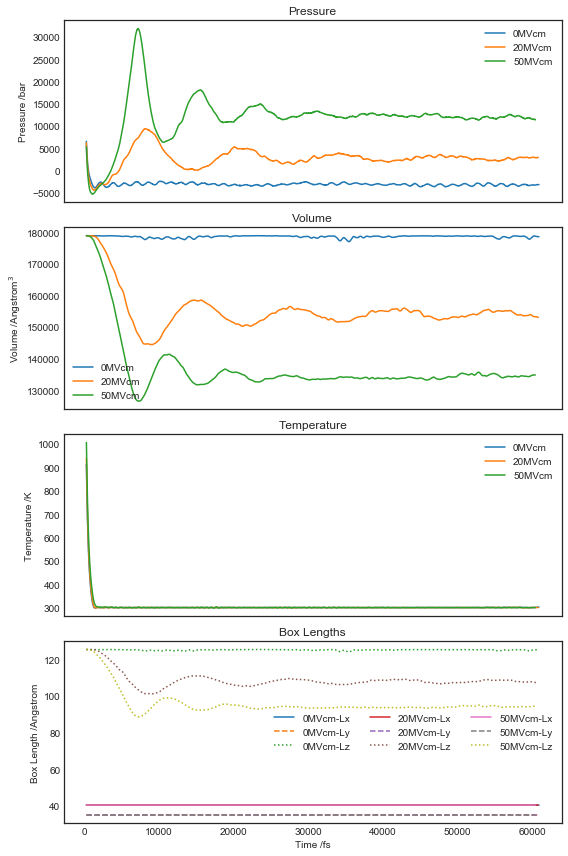

In [29]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(8, 12))
ax1.set_title('Pressure')
ax2.set_title('Volume')
ax3.set_title('Temperature')
ax4.set_title('Box Lengths')

for df, name in zip(log_dfs, [x.split('_')[-1] for x in Fe_aq_names]):
    if len(df) == 0: continue
    ax1.plot(df.index/10, df.press.rolling(5000, center=True).mean(), label = name)
    ax2.plot(df.index/10, df.vol.rolling(5000, center=True).mean(), label = name)
    ax3.plot(df.index/10, df.temp.rolling(5000, center=True).mean(), label = name)

    ax4.plot(df.index/10, df.lx.rolling(5000, center=True).mean(), label = name+'-Lx', ls = '-')
    ax4.plot(df.index/10, df.ly.rolling(5000, center=True).mean(), label = name+'-Ly', ls = '--')
    ax4.plot(df.index/10, df.lz.rolling(5000, center=True).mean(), label = name+'-Lz', ls = ':')

ax1.set_ylabel("Pressure /bar")
ax2.set_ylabel("Volume /Angstrom$^3$")
ax3.set_ylabel("Temperature /K")
ax4.set_ylabel("Box Length /Angstrom")
ax4.set_xlabel("Time /fs")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend(ncol=3)
f.tight_layout()
plt.show()

## Collate Prior Data

In [30]:
sim_list = {'trajectory': traj_lists,
            'log_df': log_dfs,
            'names': [x.split('_')[-1] for x in Fe_aq_names],
            'bonds_list': bonds_list,
            'connectivity_list': connectivity_list,
            'symbols': np.array(traj_lists[0][0].symbols)}

## Location of Atoms

In [31]:
# positions_z = []
# for traj in sim_list['trajectory']:
#     steps_to_read = np.linspace(0, len(traj)-1, 1000, dtype=int)
#     positions_z.append(np.array([traj[t].get_positions().astype(np.float32)[:, 2] for t in steps_to_read]))
# # Savinng binary somewhere
# np.save(file='Fe_aq_co2_pos_z', arr=positions_z)
# # Loading binary
sim_list['positions_z']=np.load('Fe_aq_co2_pos_z.npy')

### Visualization

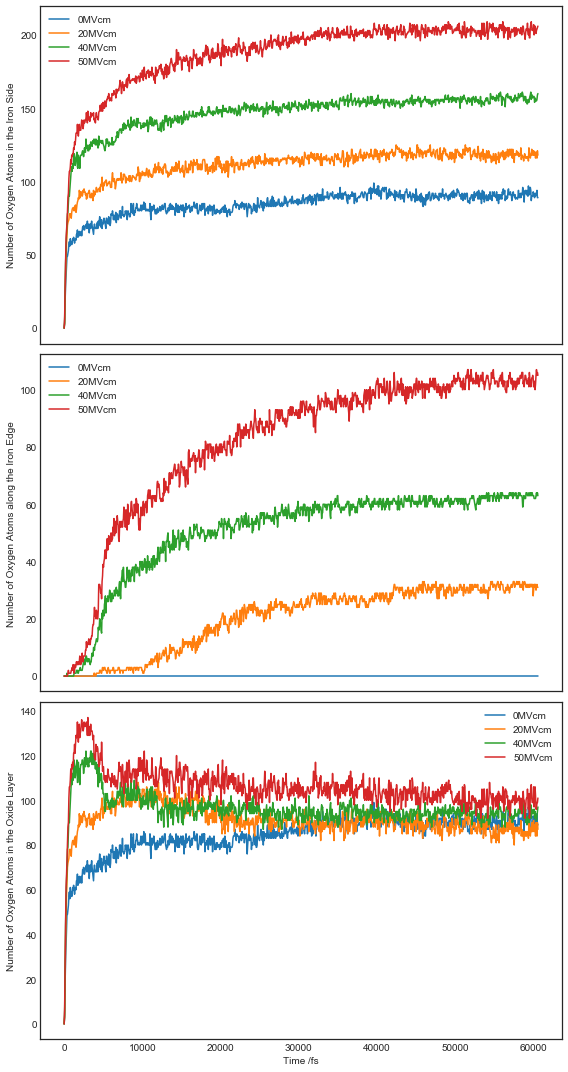

In [49]:
upper_cut_off = 97
lower_cut_off = 7

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 15), sharex=True)
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc= np.percentile(Fe_pos_z, [lower_cut_off, upper_cut_off], axis = 1)
    
    O_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(O_pos_z, Fe_perc[1])])
    O_below_lower = np.array([np.count_nonzero(i < j) for i, j in zip(O_pos_z, Fe_perc[0])])
    O_middle = O_below_upper - O_below_lower
    
    ax1.plot(steps_to_read, O_below_upper, label = name)
    ax2.plot(steps_to_read, O_below_lower, label = name)
    ax3.plot(steps_to_read, O_middle, label = name)

ax1.set_ylabel("Number of Oxygen Atoms in the Iron Side")
ax2.set_ylabel("Number of Oxygen Atoms along the Iron Edge")
ax3.set_ylabel("Number of Oxygen Atoms in the Oxide Layer")

ax3.set_xlabel("Time /fs")

for ax in [ax1, ax2, ax3]:
    ax.legend()

f.tight_layout()
f.savefig("fe_aq_co2_oxygen_distribution.png", dpi=400, )
plt.show()

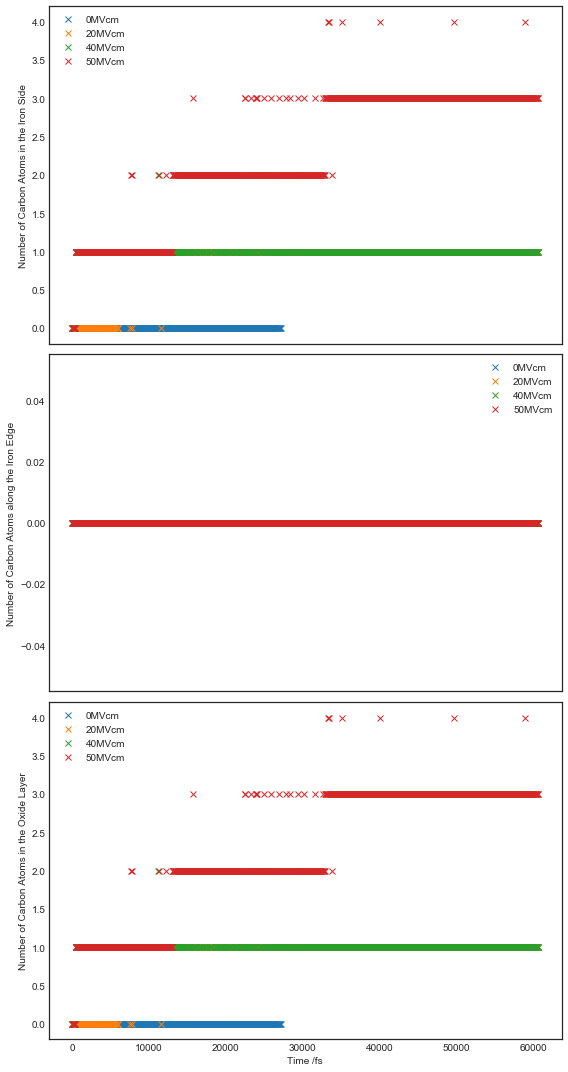

In [50]:
upper_cut_off = 97
lower_cut_off = 7

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 15), sharex=True)
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    C_pos_z = pos_z.T[sim_list['symbols']=='C'].T
    
    Fe_perc= np.percentile(Fe_pos_z, [lower_cut_off, upper_cut_off], axis = 1)
    
    C_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(C_pos_z, Fe_perc[1])])
    C_below_lower = np.array([np.count_nonzero(i < j) for i, j in zip(C_pos_z, Fe_perc[0])])
    C_middle = C_below_upper - C_below_lower
    
    ax1.plot(steps_to_read, C_below_upper, ' x', label = name)
    ax2.plot(steps_to_read, C_below_lower, ' x', label = name)
    ax3.plot(steps_to_read, C_middle, ' x', label = name)

ax1.set_ylabel("Number of Carbon Atoms in the Iron Side")
ax2.set_ylabel("Number of Carbon Atoms along the Iron Edge")
ax3.set_ylabel("Number of Carbon Atoms in the Oxide Layer")

ax3.set_xlabel("Time /fs")

for ax in [ax1, ax2, ax3]:
    ax.legend()

f.tight_layout()
f.savefig("fe_aq_co2_carbon_distribution.png", dpi=400, )
plt.show()

## Histogram of Distribution

### For Iron Atoms

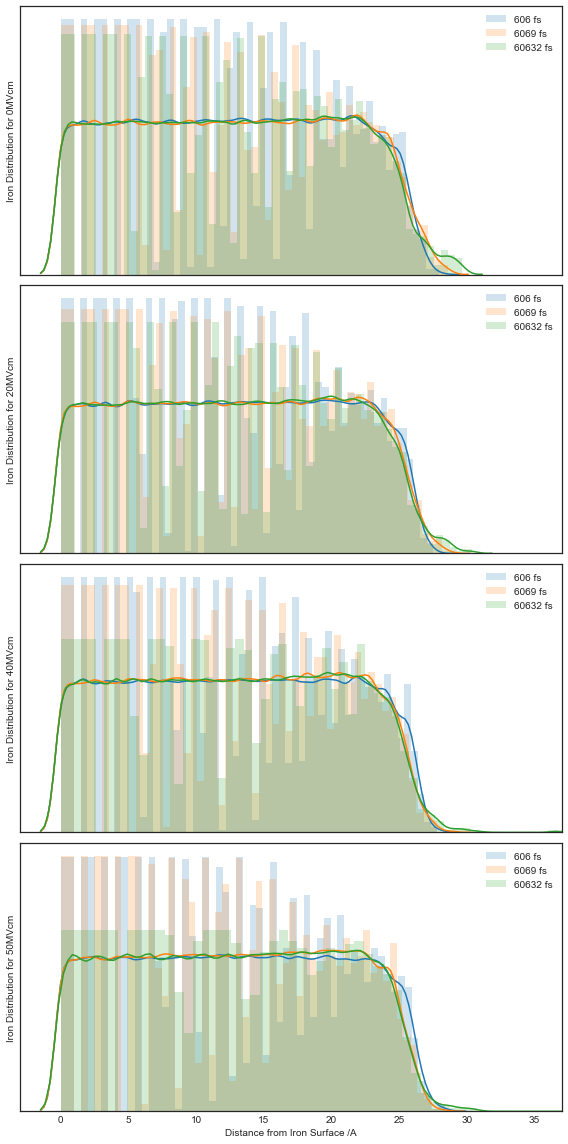

In [48]:
f, ax_arr = plt.subplots(len(sim_list['positions_z']), 1, figsize=(8, 16), sharex=True)
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    Fe_lower = np.min(Fe_pos_z, axis = 1)
    Fe_delta = np.array([i-j for i, j in zip(Fe_pos_z, Fe_lower)])
    
    sns.distplot(Fe_delta[10], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[10]))
    sns.distplot(Fe_delta[100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[100]))
    sns.distplot(Fe_delta[1000-1], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[1000-1]))
    ax1.set_xlim(-3, 37)
    ax1.set_ylabel("Iron Distribution for " + name)
    ax1.set_yticks([], [])
    ax1.legend()
    
ax_arr[-1].set_xlabel('Distance from Iron Surface /A')
    
f.tight_layout()
f.savefig("fe_aq_co2_iron_histogram.png", dpi=400)
plt.show()

### For Oxygen Atoms

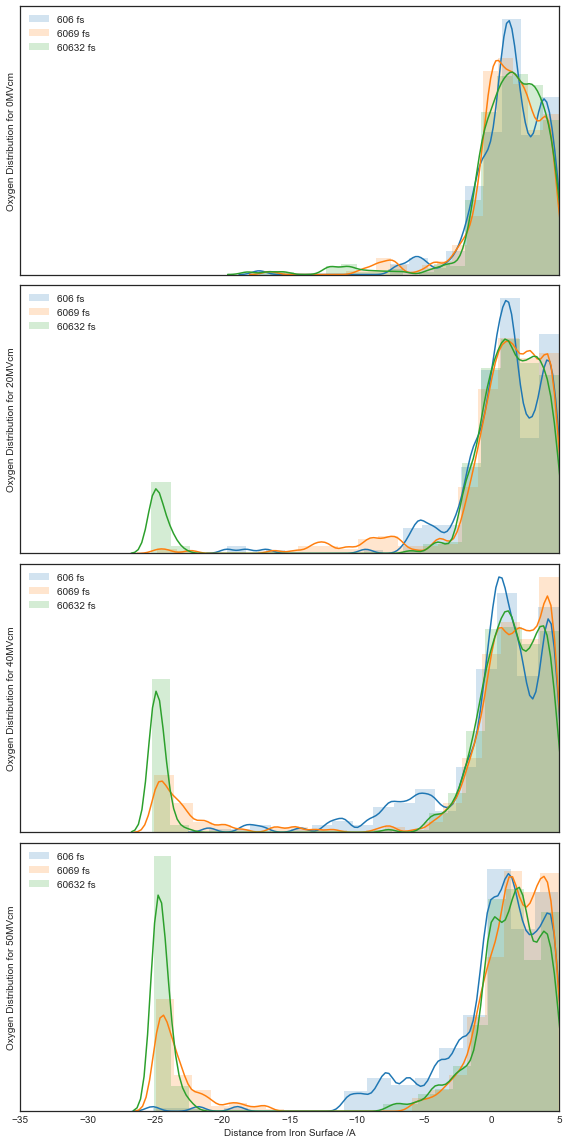

In [51]:
f, ax_arr = plt.subplots(len(sim_list['positions_z']), 1, figsize=(8, 16), sharex=True)
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc_upper = np.percentile(Fe_pos_z, 97, axis = 1)
    
    O_delta = np.array([i[i < j+5]-j for i, j in zip(O_pos_z, Fe_perc_upper)])
    
    sns.distplot(O_delta[10], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[10]))
    sns.distplot(O_delta[100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[100]))
    sns.distplot(O_delta[1000-1], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[1000-1]))
    ax1.set_xlim(-35, 5)
    ax1.set_ylabel("Oxygen Distribution for " + name)
    ax1.set_yticks([], [])
    ax1.legend()
    
ax_arr[-1].set_xlabel('Distance from Iron Surface /A')

f.tight_layout()
f.savefig("fe_aq_co2_oxygen_histogram.png", dpi=400)
plt.show()

### For Carbon Atoms

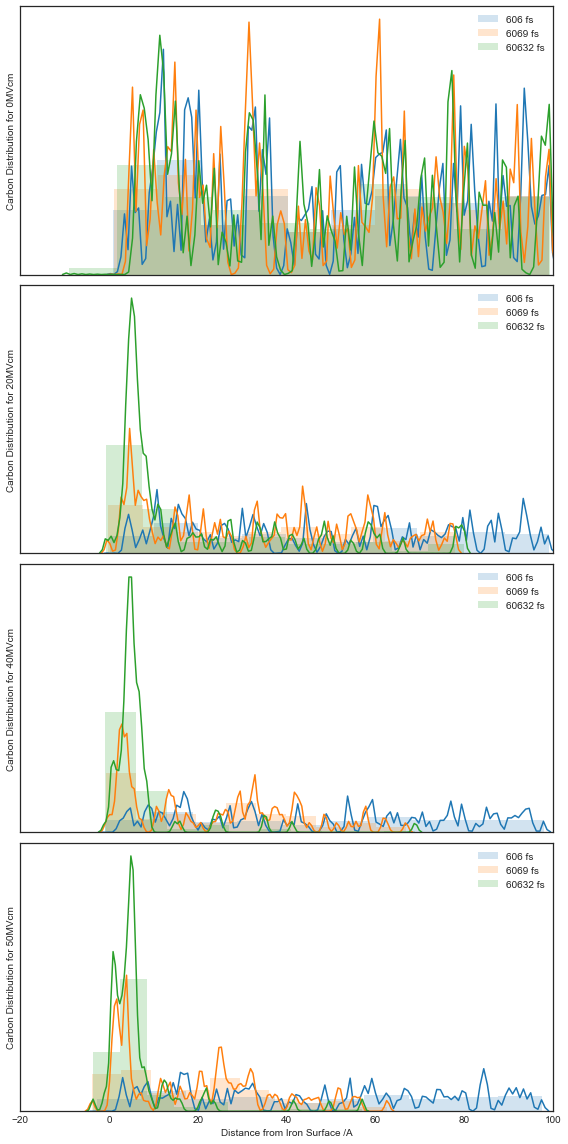

In [54]:
f, ax_arr = plt.subplots(len(sim_list['positions_z']), 1, figsize=(8, 16), sharex=True)
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    C_pos_z = pos_z.T[sim_list['symbols']=='C'].T
    
    Fe_perc_upper = np.percentile(Fe_pos_z, 97, axis = 1)
    
    C_delta = np.array([i-j for i, j in zip(C_pos_z, Fe_perc_upper)])
    
    sns.distplot(C_delta[10], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[10]))
    sns.distplot(C_delta[100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[100]))
    sns.distplot(C_delta[1000-1], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[1000-1]))
    ax1.set_xlim(-20, 100)
    ax1.set_ylabel("Carbon Distribution for " + name)
    ax1.set_yticks([], [])
    ax1.legend()
    
ax_arr[-1].set_xlabel('Distance from Iron Surface /A')

f.tight_layout()
f.savefig("fe_aq_co2_carbon_histogram_all.png", dpi=400)
plt.show()

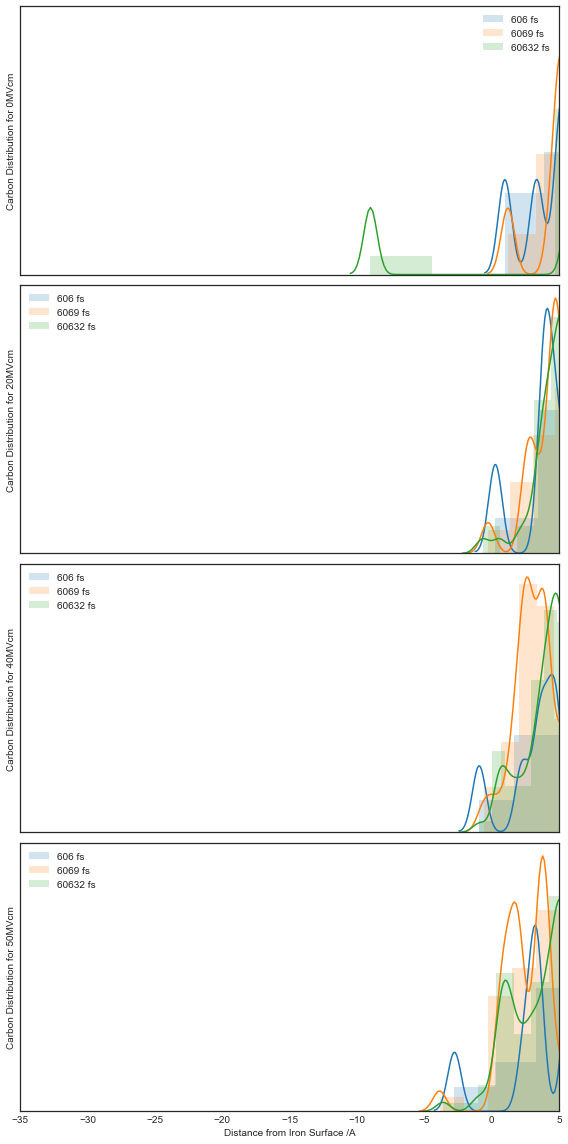

In [55]:
f, ax_arr = plt.subplots(len(sim_list['positions_z']), 1, figsize=(8, 16), sharex=True)
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    C_pos_z = pos_z.T[sim_list['symbols']=='C'].T
    
    Fe_perc_upper = np.percentile(Fe_pos_z, 97, axis = 1)
    
    C_delta = np.array([i[i < j+10]-j for i, j in zip(C_pos_z, Fe_perc_upper)])
    
    sns.distplot(C_delta[10], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[10]))
    sns.distplot(C_delta[100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[100]))
    sns.distplot(C_delta[1000-1], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[1000-1]))
    ax1.set_xlim(-35, 5)
    ax1.set_ylabel("Carbon Distribution for " + name)
    ax1.set_yticks([], [])
    ax1.legend()
    
ax_arr[-1].set_xlabel('Distance from Iron Surface /A')

f.tight_layout()
f.savefig("fe_aq_co2_carbon_histogram.png", dpi=400)
plt.show()

## Charge of Various Species

In [46]:
from ase.visualize.plot import plot_atoms
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu,
                           norm=mpl.colors.Normalize(vmin=-1., vmax=0.5))
sm.set_array([])

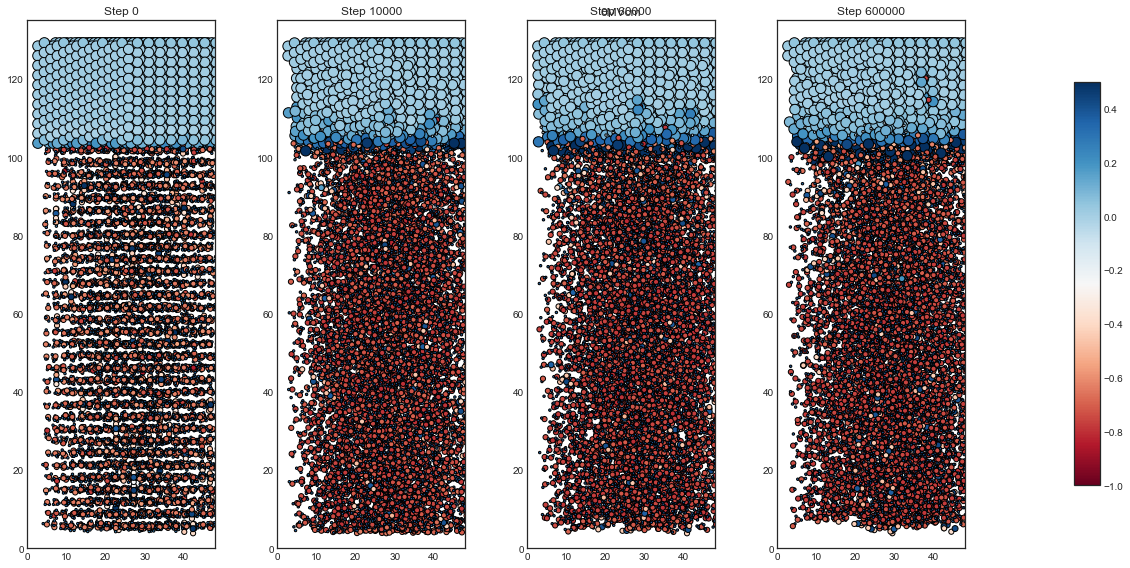

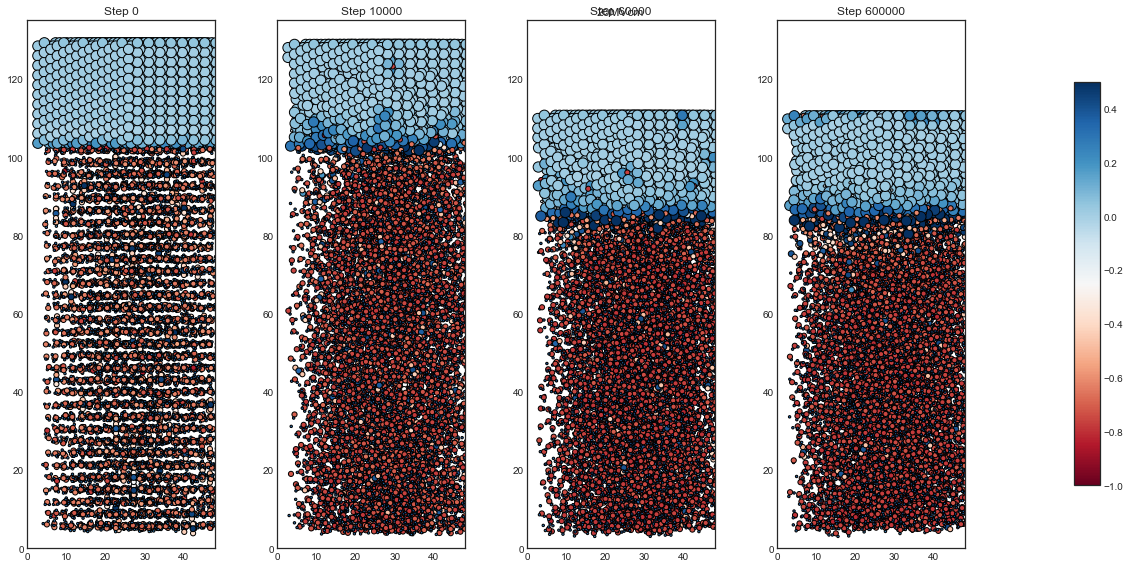

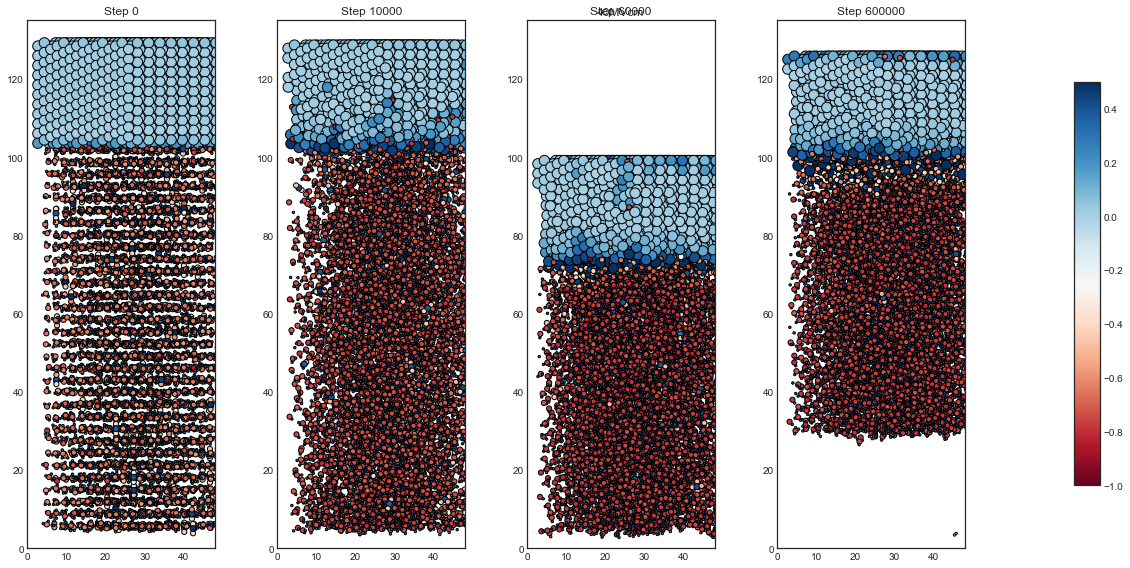

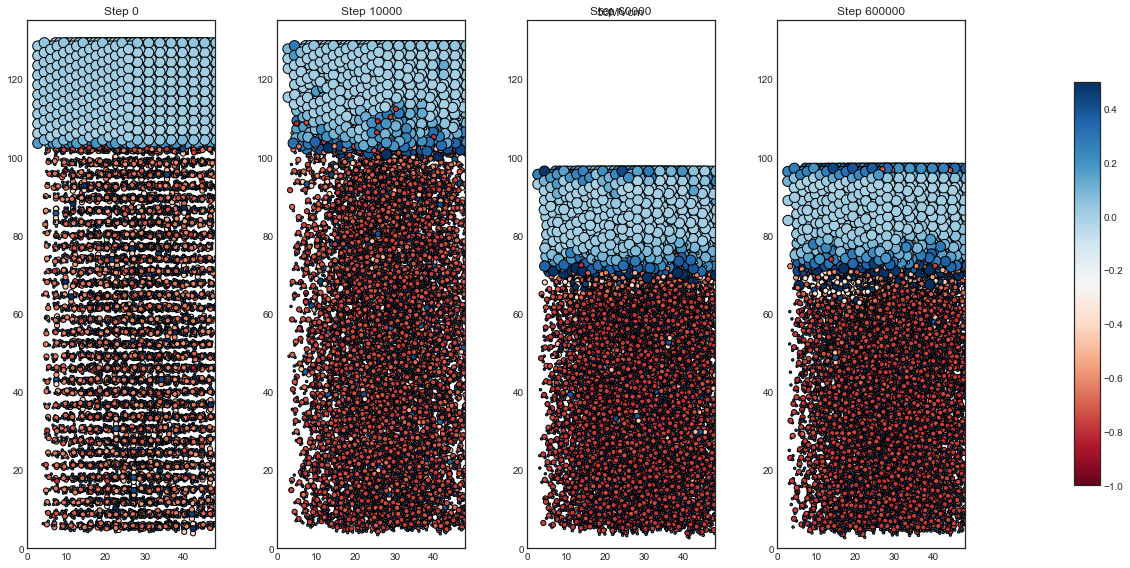

In [61]:
for traj, name, bl in zip(sim_list['trajectory'], sim_list['names'], sim_list['bonds_list']):
    f, ax_arr = plt.subplots(1, 4, figsize=(18, 8))
    
    for ax, step in zip(ax_arr, [0, 10000, 60000, 600000]):
        atom_df = pd.read_hdf(bl, key = 'step{}'.format(step//10))
        atom_color = sm.to_rgba(atom_df.charge)
        plot_atoms(traj[step//10], colors=atom_color, rotation=('90x, 45y, 0z'), ax=ax)
        ax.set_xlim(0, 48)
        ax.set_ylim(0, 135)
        ax.set_title('Step {}'.format(step))
        
    f.suptitle(name)
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
    f.colorbar(sm, cax=cbar_ax)
    
plt.show()

In [ ]:
view(sim_list['trajectory'][-1], viewer='ngl')

## Carbon Coordination

In [58]:
steps_list = np.linspace(0, 600000, 5, dtype=int)
C_index = np.argwhere(sim_list['symbols']=='C').ravel()+1

In [79]:
# Large coordinated carbon
for cl, name, traj in zip(sim_list['connectivity_list'][-1:], sim_list['names'][-1:], sim_list['trajectory'][-1:]):
    print('*'*50)
    print(name)
    print('*'*50)
    
    for step, ax in zip(steps_list, ax_arr):
        print('*'*20, 'Step', step, '*'*20)
        
        step_df = pd.read_hdf(cl, key = 'step{}'.format(step//10))
        primary_atoms = [[x] + step_df[step_df.atom_a==x].atom_b.to_list() for x in C_index]
        primary_atoms = [x for x in primary_atoms if len(x) > 3]
        
        secondary_atoms = [[[x] + step_df[step_df.atom_a==x].atom_b.to_list() for x in y] for y in primary_atoms]
        atoms_to_plot = [list(set([x for y in z for x in y])) for z in secondary_atoms]
        
        atoms_to_plot = [x for x in atoms_to_plot if np.any(traj[step//10][np.array(x)-1].get_positions()[:, 2]<35)]
        
        for atoms in atoms_to_plot:
#             f, ax = plt.subplots(figsize = (5, 5))
#             plot_atoms(traj[step][np.array(atoms)-1], ax = ax, rotation=('90x,40y,0z'))
            view(traj[step//10][np.array(atoms)-1])
#             ax.set_title('Step {}'.format(step))
#             plt.show()
# #         print(len(connected_atoms))
#         coordination = np.array([len(x) for x in connected_atoms])
        

**************************************************
50MVcm
**************************************************
******************** Step 0 ********************
******************** Step 150000 ********************
******************** Step 300000 ********************
******************** Step 450000 ********************
******************** Step 600000 ********************


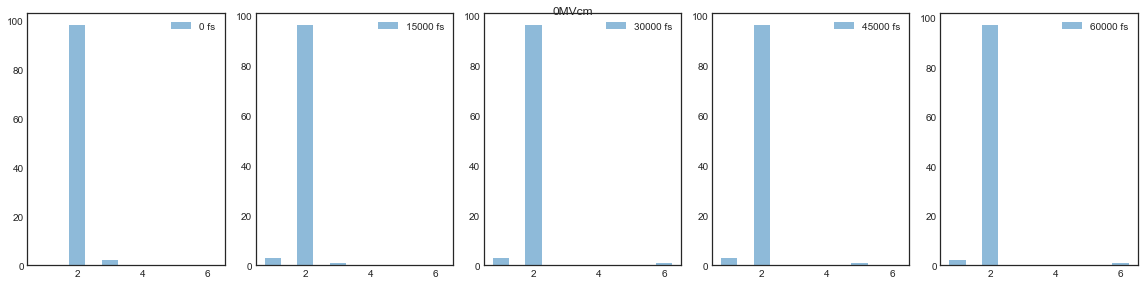

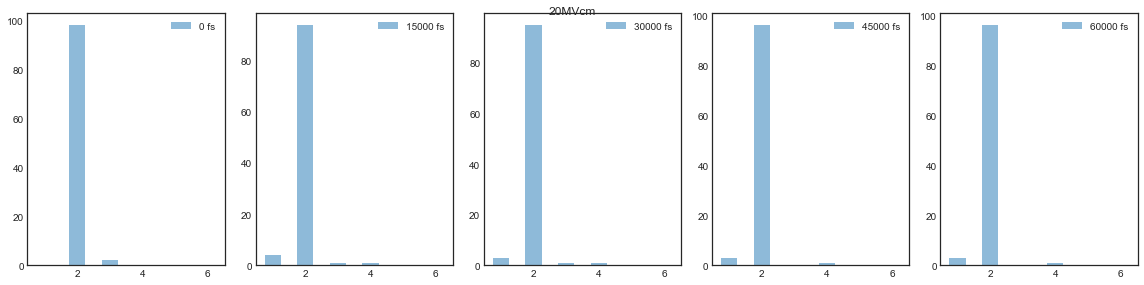

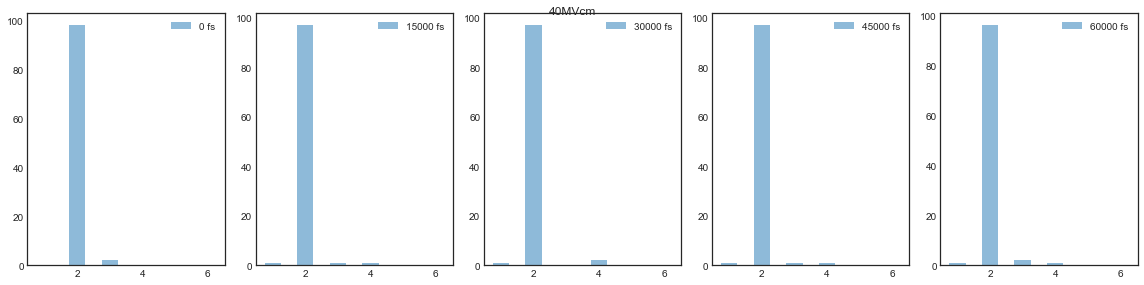

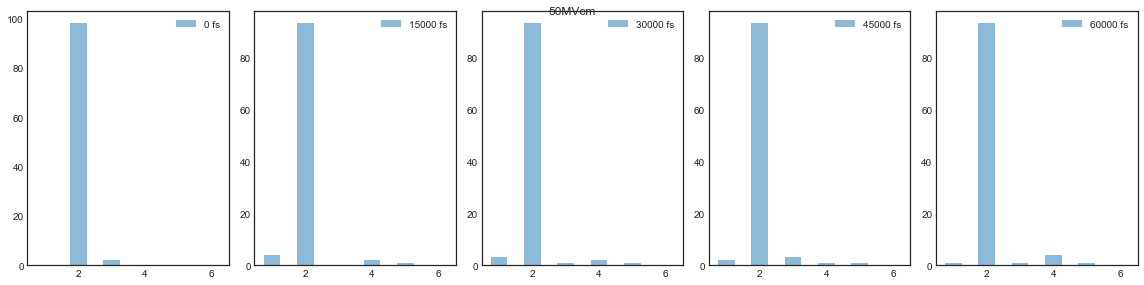

In [62]:
for cl, name in zip(sim_list['connectivity_list'], sim_list['names']):
    f, ax_arr = plt.subplots(1, 5, figsize=(16, 4))

    for step, ax in zip(steps_list, ax_arr):
        step_df = pd.read_hdf(cl, key = 'step{}'.format(step//10))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in C_index])
        
        sns.distplot(coordination, kde=False,
                     bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
                     hist_kws={'alpha': 0.5, 'align': 'mid', 'rwidth': 0.5},
                     ax=ax, label = '{} fs'.format(step//10))
        ax.legend()
        
    f.tight_layout()
    f.suptitle(name)
plt.show()

## Radial Distribution Function

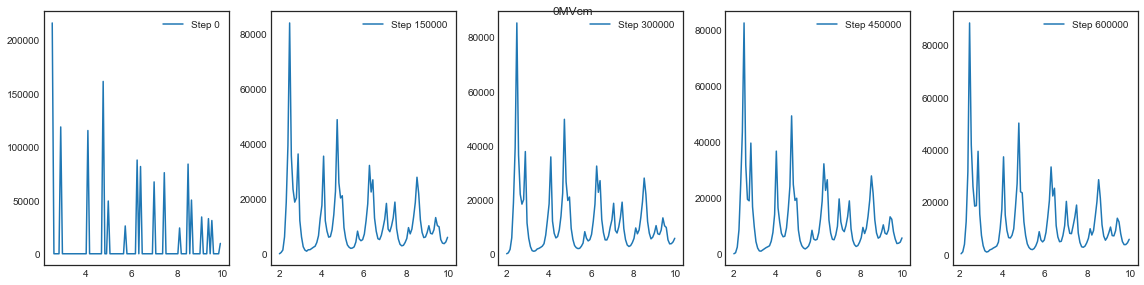

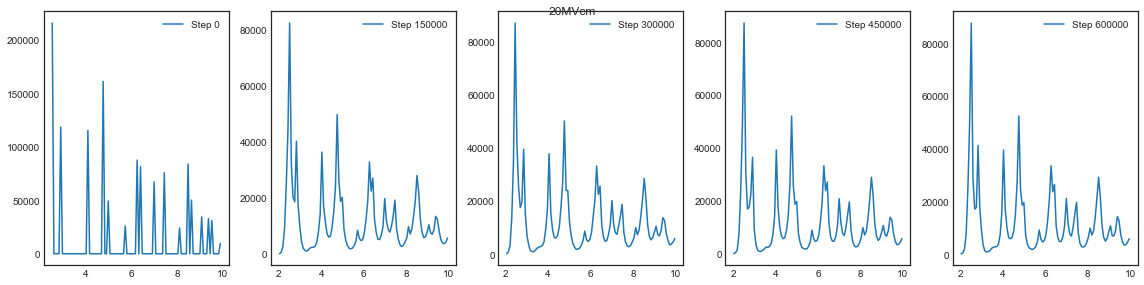

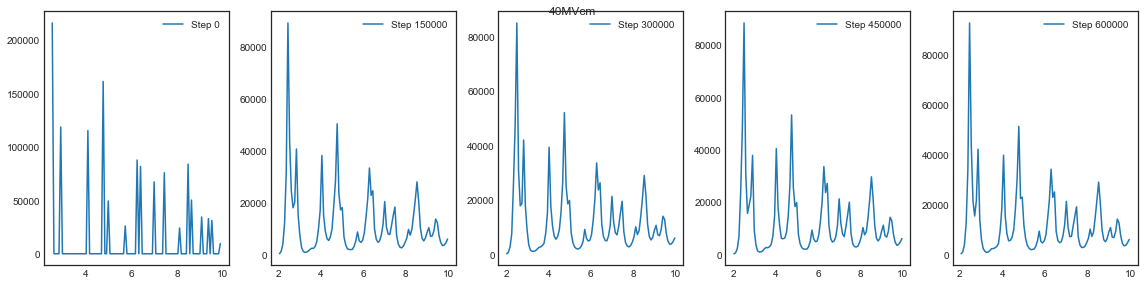

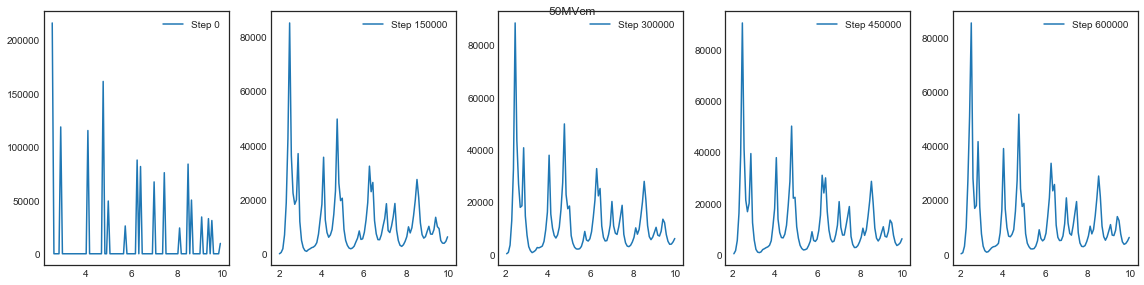

In [65]:
from ase.neighborlist import neighbor_list
for traj, name in zip(sim_list['trajectory'], sim_list['names']):
    f, ax_arr = plt.subplots(1, 5, figsize=(16, 4))
    
    for ax, step in zip(ax_arr, steps_list):
        fe_only = traj[step//10][sim_list['symbols'] == 'Fe']
        d = neighbor_list('d', fe_only, 10.00)
        h, bin_edges = np.histogram(d, bins=100)
        pdf = h/(4*np.pi/3*(bin_edges[1:]**3 - bin_edges[:-1]**3)) * fe_only.get_volume()/len(fe_only)
        x_axis = (bin_edges[1: ] + bin_edges[:-1])/2
        
        ax.plot(x_axis, pdf, label = '{} fs'.format(step//10))
        ax.legend()
    f.suptitle(name)
    f.tight_layout()
    
plt.show()

## Carbon Molecules

In [74]:
def plot_connected_molecule_from_df(atom_id, step_df):
    import networkx as nx
    from ase.data.colors import jmol_colors
    from ase.data import atomic_numbers
    G = nx.from_pandas_edgelist(
        step_df, source='atom_a', target='atom_b', edge_attr=['bond_order'])
    G_connected = nx.connected_components(G)
    for i in G_connected:
        if atom_id in i:
            if len(i) > 16:
                print("The atom {} connected to {} other atom is probably a bulk molecule. Not plotting.".format(atom_id, len(i)))
                break
            fig = plt.figure(figsize=(3, 3))

            sub_G = G.subgraph(i)
            edge_labels = nx.get_edge_attributes(sub_G, 'bond_order')
            node_labels = dict(
                zip(i, sim_list['symbols'][np.array(list(i))-1]))
            colors = [jmol_colors[atomic_numbers[v]] for k, v in node_labels.items()]

            pos = nx.spring_layout(sub_G)

            nx.draw(sub_G, pos, node_color=colors)
            nx.draw_networkx_labels(sub_G, pos,  node_labels)
    #         nx.draw_networkx_edge_labels(sub_G, pos, edge_labels)
            fig.set_facecolor("#c9c9c9")

**************************************************
0MVcm
**************************************************


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']
The atom 16779 connected to 4112 other atom is probably a bulk molecule. Not plotting.
['O' 'Fe' 'O']
The atom 16779 connected to 4192 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe' 'Fe']
The atom 16779 connected to 4221 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe']
The atom 16779 connected to 4265 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe' 'Fe']
**************************************************
20MVcm
**************************************************


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']
The atom 16779 connected to 4170 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 16779 connected to 4230 other atom is probably a bulk molecule. Not plotting.
['Fe' 'O' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
**************************************************
40MVcm
**************************************************


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']
The atom 16779 connected to 4180 other atom is probably a bulk molecule. Not plotting.
['Fe' 'O' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 16779 connected to 4230 other atom is probably a bulk molecule. Not plotting.
['Fe' 'O' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 16779 connected to 4244 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 16779 connected to 4250 other atom is probably a bulk molecule. Not plotting.
['Fe' 'O' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 16887 connected to 4250 other atom is probably a bulk molecule. Not plotting.
['O' 'O' 'Fe']
**************************************************
50MVcm
**************************************************


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['H' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'H' 'O' 'O']
The atom 16779 connected to 4253 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe']
The atom 16881 connected to 4253 other atom is probably a bulk molecule. Not plotting.
['O' 'Fe' 'Fe' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'H' 'O']
The atom 16779 connected to 4300 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']
The atom 16881 connected to 4300 other atom is probably a bulk molecule. Not plotting.
['Fe' 'O' 'O' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'H' 'O']


D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']
The atom 16779 connected to 4319 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']
The atom 16881 connected to 4319 other atom is probably a bulk molecule. Not plotting.
['Fe' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'H']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O']
The atom 16779 connected to 4330 other atom is probably a bulk molecule. Not plotting.
['Fe' 'Fe' 'Fe' 'Fe' 'Fe']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


['O' 'O' 'O' 'O']
The atom 16881 connected to 4330 other atom is probably a bulk molecule. Not plotting.
['Fe' 'O' 'O' 'Fe']


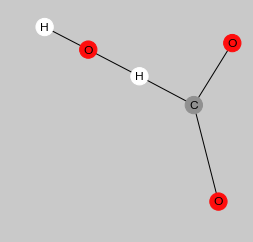

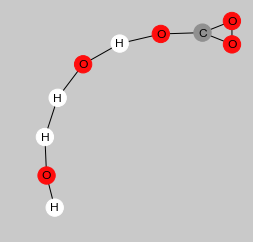

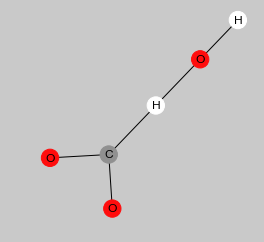

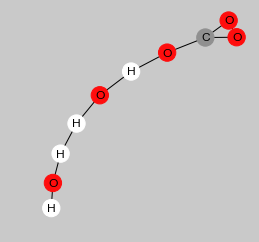

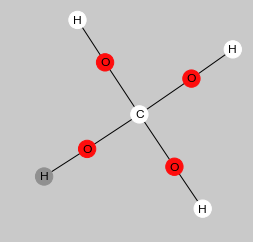

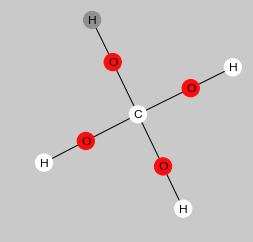

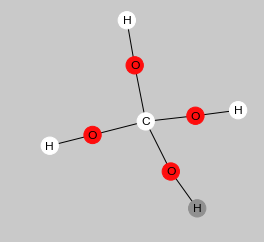

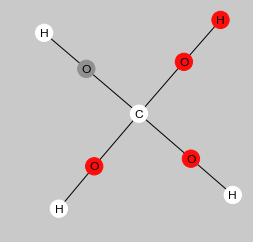

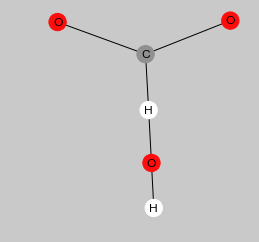

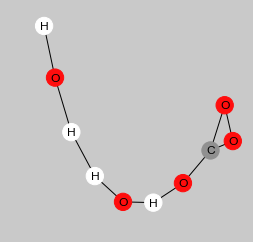

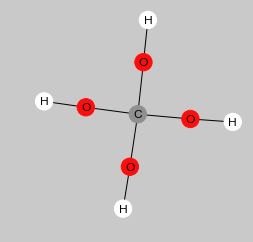

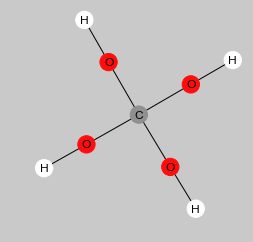

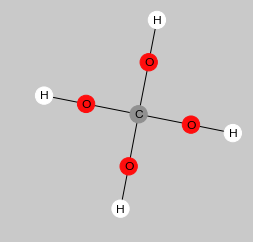

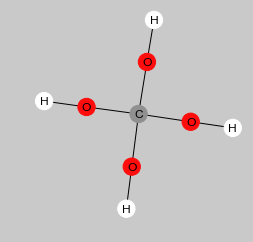

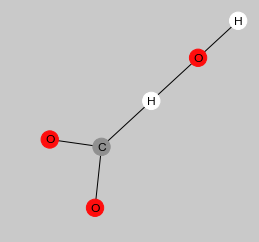

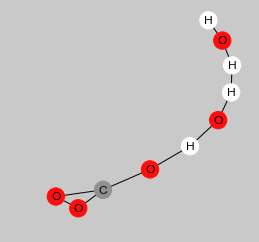

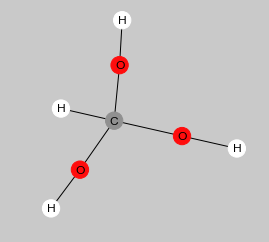

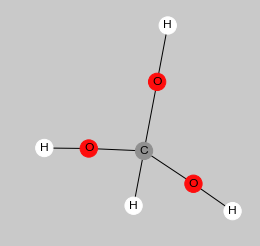

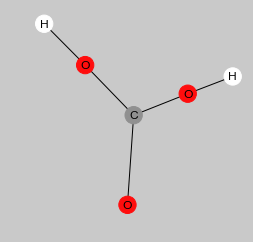

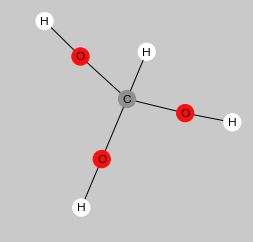

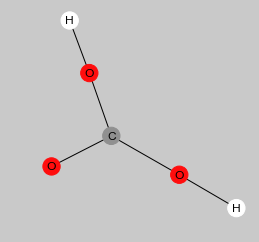

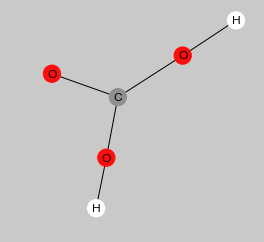

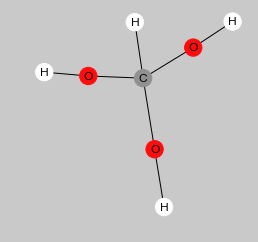

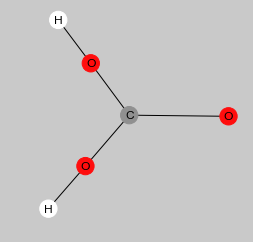

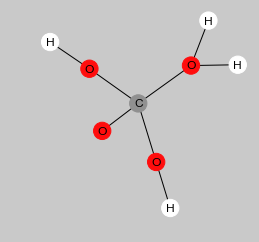

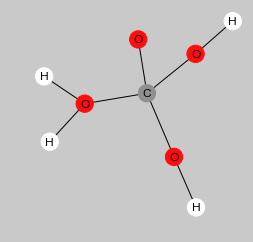

In [83]:
for cl, name in zip(sim_list['connectivity_list'], sim_list['names']):
    print('*'*50)
    print(name)
    print('*'*50)
    for step, ax in zip(steps_list, ax_arr):
        step_df = pd.read_hdf(cl, key = 'step{}'.format(step//10))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in C_index])
        
        for i in C_index[coordination>2]:
            plot_connected_molecule_from_df(i, step_df)
            conn_df = step_df[step_df.atom_a == i]
            print(sim_list['symbols'][conn_df.atom_b-1])

## Carbon Molecule Tracking

In [109]:
import networkx as nx
from ase.data.colors import jmol_colors
from ase.data import atomic_numbers


for cl, name in zip(sim_list['connectivity_list'][-1:], sim_list['names'][-1:]):
    step_molecules = []
    print('*'*50)
    print(name)
    print('*'*50)
    
    for step, ax in zip(steps_list, ax_arr):
        step_df = pd.read_hdf(cl, key = 'step{}'.format(step//10))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in C_index])
        G = nx.from_pandas_edgelist(step_df, source='atom_a', target='atom_b', edge_attr=['bond_order'])
        molecule_collection = []
        for i in C_index[coordination>1]:
            for G_subset in nx.connected_components(G):
                if i in G_subset:
                    molecule =  sim_list['symbols'][np.array(list(G_subset))-1]
                    elements, subscripts = np.unique(molecule, return_counts=True)
                    molecule_collection.append(''.join(["{}{}".format(a, b) if b > 1 else "{}".format(a) for (a, b)in zip(elements, subscripts)]))
        molecule_collection_unique = np.unique(np.array(molecule_collection), return_counts=True)
        molecule_dict = dict(zip(molecule_collection_unique[0], molecule_collection_unique[1]))
        step_molecules.append(molecule_dict)

**************************************************
50MVcm
**************************************************


In [114]:
pd.DataFrame(step_molecules, index=steps_list)

C2Fe3199H723O376  C2Fe3199H734O384  C2Fe3199H741O388  \
0                    NaN               NaN               NaN   
150000               NaN               NaN               NaN   
300000               2.0               NaN               NaN   
450000               NaN               2.0               NaN   
600000               NaN               NaN               2.0   

        C2Fe3200H242O125  C2Fe3200H692O359  C2H2O5  C2H6O7  CH2O3  CH4O3  \
0                    2.0               NaN     6.0     2.0   43.0    NaN   
150000               NaN               2.0     NaN     NaN    NaN    1.0   
300000               NaN               NaN     NaN     NaN    1.0    1.0   
450000               NaN               NaN     NaN     NaN    2.0    1.0   
600000               NaN               NaN     NaN     NaN    1.0    1.0   

        CH4O4  CH4O5  CO2  
0        10.0    1.0   36  
150000    NaN    NaN   93  
300000    NaN    NaN   93  
450000    NaN    NaN   93  
600000    2.0    NaN   93

In [ ]:

    G = nx.from_pandas_edgelist(
        step_df, source='atom_a', target='atom_b', edge_attr=['bond_order'])
    G_connected = nx.connected_components(G)
    for i in G_connected:
        if atom_id in i:
            if len(i) > 16:
                print("The atom {} connected to {} other atom is probably a bulk molecule. Not plotting.".format(atom_id, len(i)))
                break
            fig = plt.figure(figsize=(3, 3))

            sub_G = G.subgraph(i)
            edge_labels = nx.get_edge_attributes(sub_G, 'bond_order')
            node_labels = dict(
                zip(i, sim_list['symbols'][np.array(list(i))-1]))
            colors = [jmol_colors[atomic_numbers[v]] for k, v in node_labels.items()]

            pos = nx.spring_layout(sub_G)

            nx.draw(sub_G, pos, node_color=colors)
            nx.draw_networkx_labels(sub_G, pos,  node_labels)
    #         nx.draw_networkx_edge_labels(sub_G, pos, edge_labels)
            fig.set_facecolor("#c9c9c9")

## Backup Animation Production and Saving

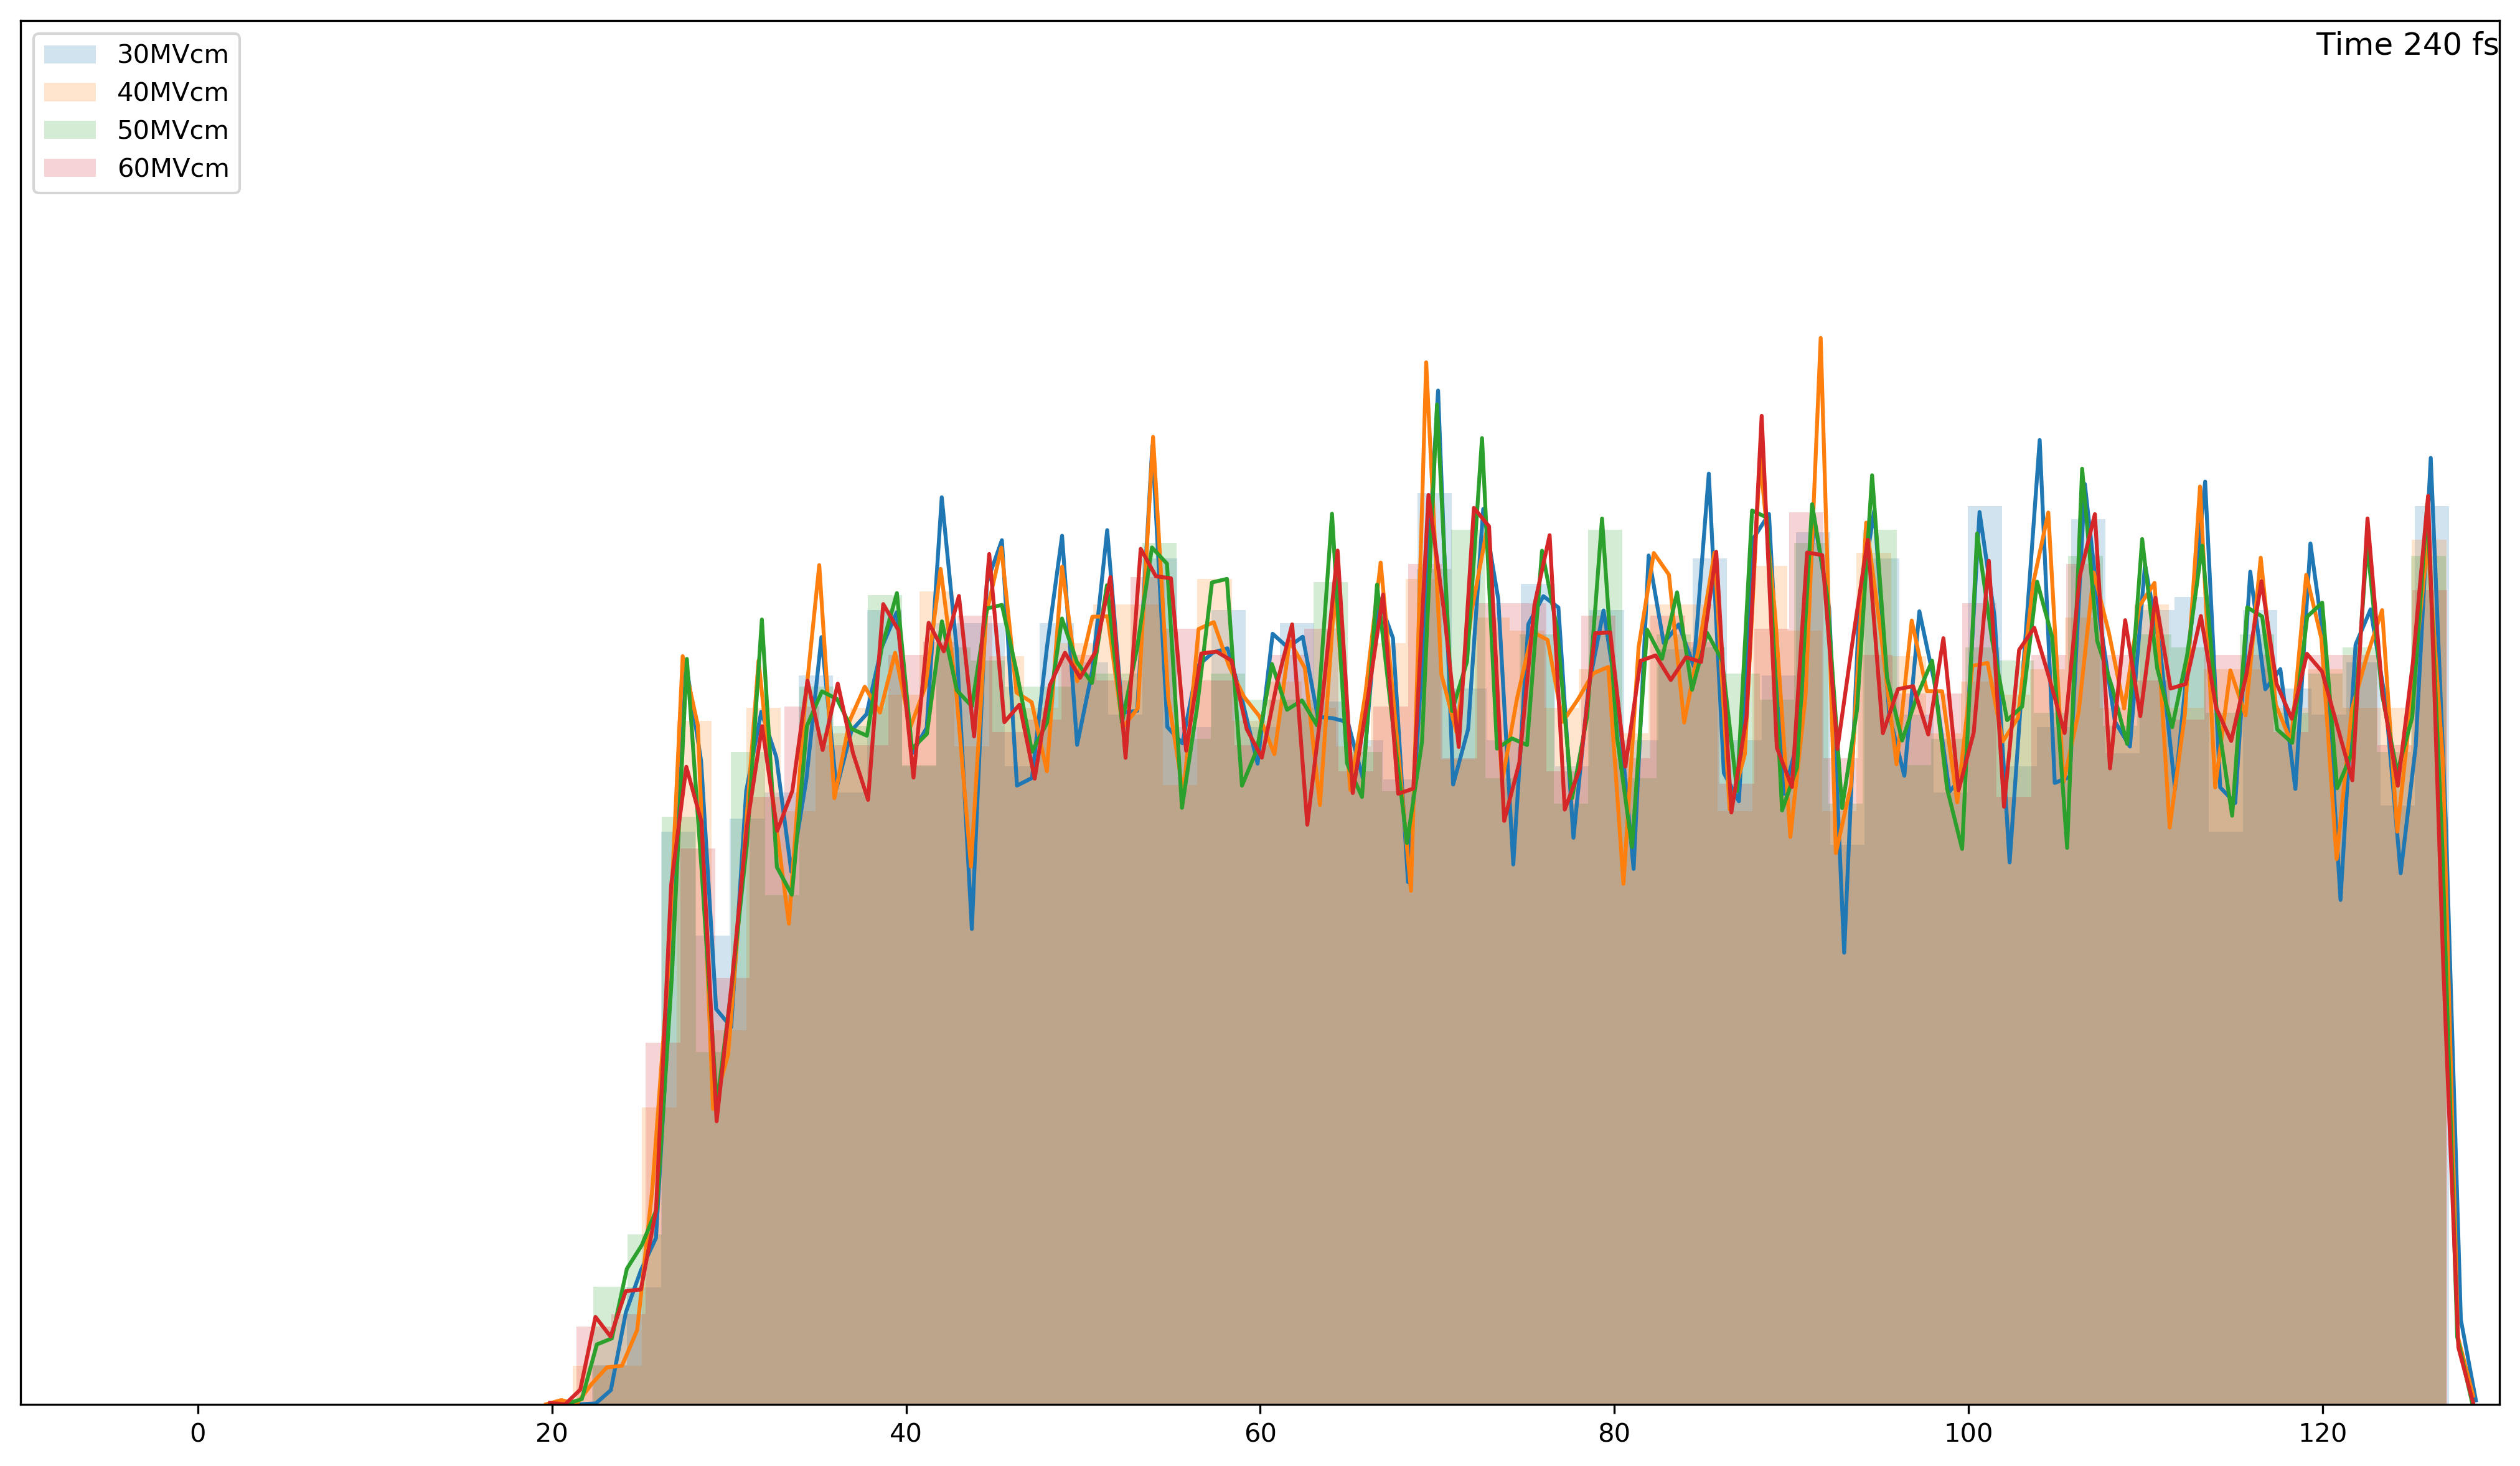

In [125]:
import subprocess

def testSubprocess(outf='testSubprocess.mp4', nframes=1):

    #set up the figure
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.tight_layout()
    fig.set_dpi(300)
    canvas_width, canvas_height = fig.canvas.get_width_height()
    
    # First frame
    ax.tick_params(labelleft=False, left=False)
    sns.kdeplot([], ax = ax)
    ax.set_xlim(-10, 130)
    ax.set_ylim(0, 0.019)

    def update(num):
            ax.clear()
            sns.distplot(sim_list['O_pos_z'][0][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][0])
            sns.distplot(sim_list['O_pos_z'][1][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][1])
            sns.distplot(sim_list['O_pos_z'][2][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][2])
            sns.distplot(sim_list['O_pos_z'][3][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][3])
            ax.set_title('Time {} fs'.format(num*10), loc='right', pad=-13)
            ax.set_xlim(-10, 130)
            ax.set_ylim(0, 0.019)
            ax.legend(loc=2)

    # Open an ffmpeg process
    cmdstring = ('/local/yiming/miniconda3/bin/ffmpeg', 
                 '-y', '-r', '25', # overwrite
                 '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
                 '-pix_fmt', 'argb', # format
                 '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
                 '-crf', '20',
                 '-vcodec', 'libx264', outf) # output encoding
    p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

    # Draw frames and write to the pipe
    for frame in range(nframes):
        # draw the frame
        update(frame)
        fig.canvas.draw()

        # extract the image as an ARGB string
        string = fig.canvas.tostring_argb()

        # write to pipe
        p.stdin.write(string)

    # Finish up
    p.communicate()

testSubprocess(outf='Fe_H2O_efield.mp4', nframes=len(sim_list['O_pos_z'][0]))

## backup nx graphing